In [314]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [237]:
fuel_pricedf=pd.read_csv('/Users/sumitkumar/Downloads/weeklyFuel_Italy.csv')

In [238]:
fuel_pricedf.head(10)

,survey_date,product_id,product_name,price,vat,excise,net,change
0,1/3/05,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,1/3/05,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,1/3/05,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,1/3/05,5,LPG,552.50,92.08,156.62,303.80,0.22
4,1/3/05,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
5,1/3/05,8,Heavy fuel oil,229.52,0.00,31.39,198.13,-5.37
6,1/10/05,1,Euro-Super 95,1088.00,181.33,558.64,348.03,-27.75
7,1/10/05,2,Automotive gas oil,1004.39,167.40,403.21,433.78,-13.89
8,1/10/05,3,Heating gas oil,947.94,157.99,403.21,386.74,-0.56
9,1/10/05,5,LPG,552.57,92.09,156.62,303.86,0.07


In [239]:
fuel_pricedf.shape

(5358, 8)

#### Diving the dataset into indicidual oil datasets

In [240]:
eurofuel=fuel_pricedf[fuel_pricedf['product_id']==1]
automotive_oil=fuel_pricedf[fuel_pricedf['product_id']==2]
heating_gas=fuel_pricedf[fuel_pricedf['product_id']==3]
lpg=fuel_pricedf[fuel_pricedf['product_id']==5]
residual_fuel=fuel_pricedf[fuel_pricedf['product_id']==6]
heavy_oil=fuel_pricedf[fuel_pricedf['product_id']==8]



### Data Preprocessing

In [241]:
eurofuel.isnull().sum()
automotive_oil.isnull().sum()
heating_gas.isnull().sum()
lpg.isnull().sum()
residual_fuel.isnull().sum()
heavy_oil.isnull().sum()

survey_date     0
product_id      0
product_name    0
price           0
vat             0
excise          0
net             0
change          0
dtype: int64

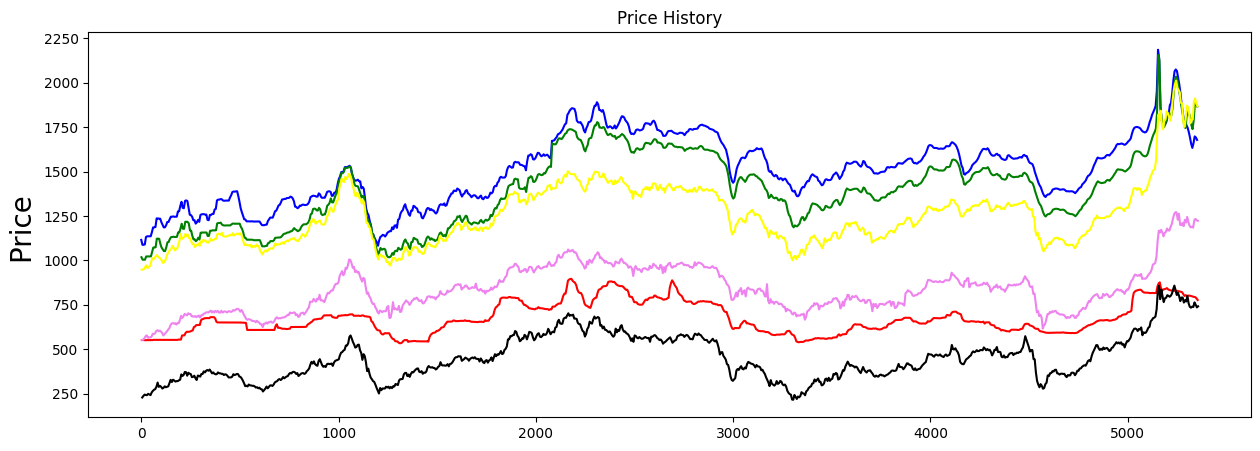

In [242]:
plt.figure(figsize=(15,5))
plt.title('Price History')
plt.plot(eurofuel['price'],label='Eurofuel',color='blue')
plt.plot(automotive_oil['price'],label='Automotive Oil',color='green')
plt.plot(heating_gas['price'],label='Heating gas',color='yellow')
plt.plot(lpg['price'],label='LPG',color='red')
plt.plot(residual_fuel['price'],label='Residual Fuel',color='violet')
plt.plot(heavy_oil['price'], label='Heavy oil',color='black')
plt.ylabel('Price ', fontsize=20)
plt.show()

In [243]:
eurofuel=eurofuel[['survey_date','price']].copy()
automotive_oil=automotive_oil[['survey_date','price']].copy()
heating_gas=heating_gas[['survey_date','price']].copy()
lpg=lpg[['survey_date','price']].copy()
residual_fuel=residual_fuel[['survey_date','price']].copy()
heavy_oil=heavy_oil[['survey_date','price']].copy()

eurofuel.set_index('survey_date', inplace=True)
automotive_oil.set_index('survey_date', inplace=True)
heating_gas.set_index('survey_date', inplace=True)
lpg.set_index('survey_date', inplace=True)
residual_fuel.set_index('survey_date', inplace=True)
heavy_oil.set_index('survey_date', inplace=True)

In [244]:
print('Eurofuel {}'.format( eurofuel.describe()))
print('Automotive {}'.format(automotive_oil.describe()))
print('Heating Gas {}'.format(heating_gas.describe()))
print('LPG {}'.format(lpg.describe()))
print('Residual Fuel {}'.format(residual_fuel.describe()))
print('Heavy Oil {}'.format(heavy_oil.describe()))

Eurofuel              price
count   893.000000
mean   1506.267660
std     194.334325
min    1082.640000
25%    1358.880000
50%    1518.550000
75%    1642.690000
max    2184.580000
Automotive              price
count   893.000000
mean   1394.341389
std     212.841307
min    1004.310000
25%    1212.620000
50%    1396.530000
75%    1524.630000
max    2154.630000
Heating Gas              price
count   893.000000
mean   1253.591120
std     181.007899
min     947.940000
25%    1120.060000
50%    1221.460000
75%    1371.950000
max    2011.590000
LPG             price
count  893.000000
mean   673.247895
std     88.628801
min    534.370000
25%    609.370000
50%    655.240000
75%    740.390000
max    896.270000
Residual Fuel              price
count   893.000000
mean    835.841456
std     132.892469
min     553.250000
25%     730.650000
50%     825.930000
75%     934.930000
max    1270.910000
Heavy Oil             price
count  893.000000
mean   452.490045
std    128.558438
min    216.740000
25% 

### Test for Stationarity

#### Plotting Rolling Statistics:
Plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique

#### Dickey-Fuller Test:
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be accepted or rejected. The result must be interpreted for a given problem to be meaningful.



#### Null Hypothesis (H0):
If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.



#### Alternate Hypothesis (H1):

The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [307]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries['price'].rolling(window=5).mean()
    rolstd = timeseries['price'].rolling(window=5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

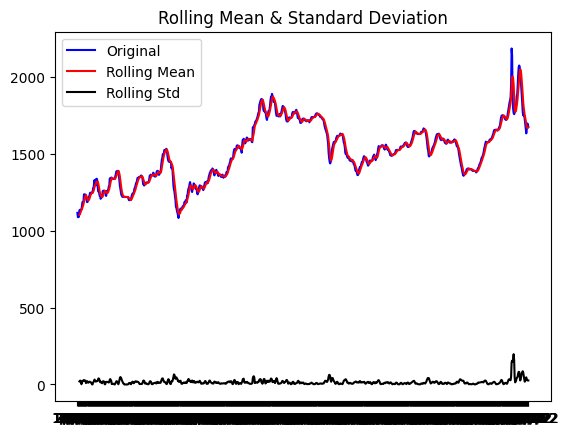

Results of Dickey-Fuller Test:
Test Statistic                  -2.128070
p-value                          0.233378
#Lags Used                      10.000000
Number of Observations Used    882.000000
Critical Value (1%)             -3.437786
Critical Value (5%)             -2.864822
Critical Value (10%)            -2.568518
dtype: float64


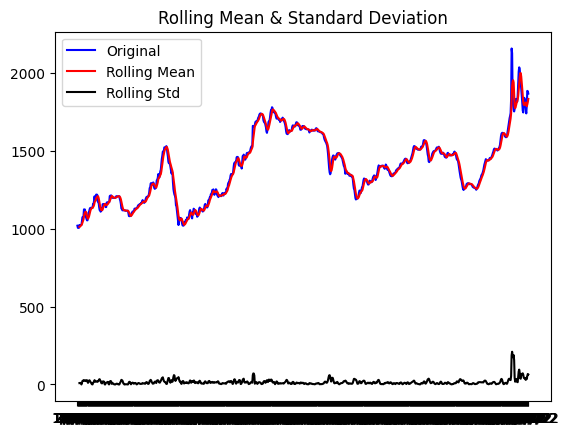

Results of Dickey-Fuller Test:
Test Statistic                  -1.643063
p-value                          0.460661
#Lags Used                       7.000000
Number of Observations Used    885.000000
Critical Value (1%)             -3.437761
Critical Value (5%)             -2.864811
Critical Value (10%)            -2.568512
dtype: float64


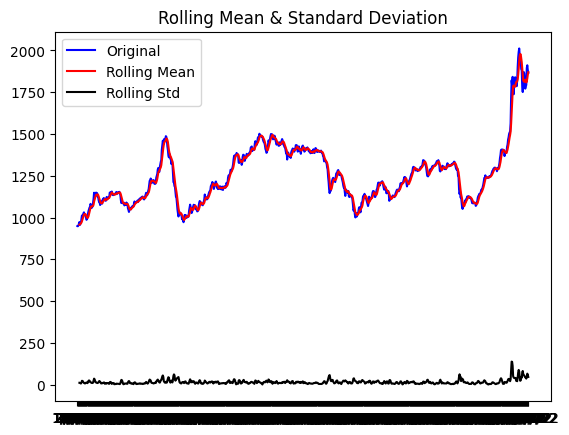

Results of Dickey-Fuller Test:
Test Statistic                  -1.274952
p-value                          0.640552
#Lags Used                       6.000000
Number of Observations Used    886.000000
Critical Value (1%)             -3.437752
Critical Value (5%)             -2.864808
Critical Value (10%)            -2.568510
dtype: float64


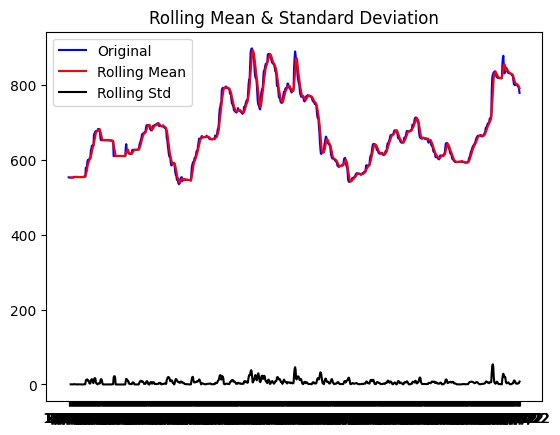

Results of Dickey-Fuller Test:
Test Statistic                  -2.765036
p-value                          0.063444
#Lags Used                       4.000000
Number of Observations Used    888.000000
Critical Value (1%)             -3.437735
Critical Value (5%)             -2.864800
Critical Value (10%)            -2.568506
dtype: float64


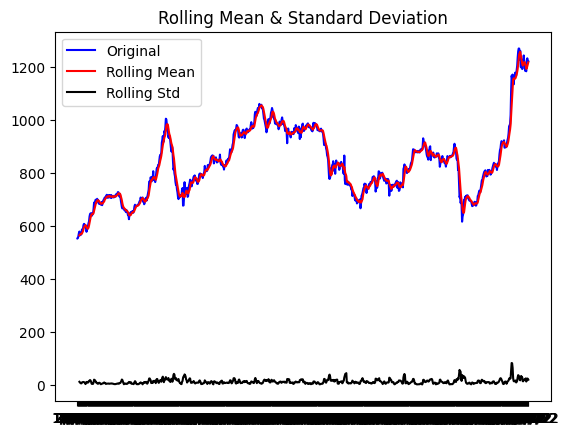

Results of Dickey-Fuller Test:
Test Statistic                  -1.457473
p-value                          0.554434
#Lags Used                       5.000000
Number of Observations Used    887.000000
Critical Value (1%)             -3.437744
Critical Value (5%)             -2.864804
Critical Value (10%)            -2.568508
dtype: float64


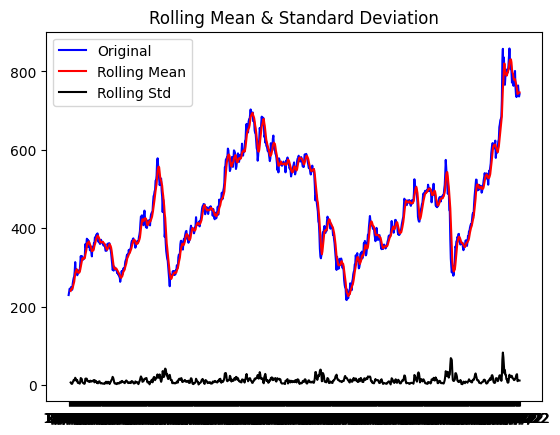

Results of Dickey-Fuller Test:
Test Statistic                  -1.835024
p-value                          0.363217
#Lags Used                       3.000000
Number of Observations Used    889.000000
Critical Value (1%)             -3.437727
Critical Value (5%)             -2.864797
Critical Value (10%)            -2.568504
dtype: float64


In [308]:
test_stationarity(eurofuel)
test_stationarity(automotive_oil)
test_stationarity(heating_gas)
test_stationarity(lpg)
test_stationarity(residual_fuel)
test_stationarity(heavy_oil)

### For all the fuel type, we see that we need to accept NULL Hypothesis, Now we will work on removing the seasonality

In [309]:
eurofuel_log=np.log(eurofuel)
automotive_oil_log=np.log(automotive_oil)
heating_gas_log=np.log(heating_gas)
lpg_log=np.log(lpg)
residual_fuel_log=np.log(residual_fuel)
heavy_oil_log=np.log(heavy_oil)

In [310]:
eurofuel_log_diff = eurofuel_log - eurofuel_log.shift()
automotive_oil_log_diff = automotive_oil_log - automotive_oil_log.shift()
heating_gas_log_diff = heating_gas_log - heating_gas_log.shift()
lpg_log_diff = lpg_log - lpg_log.shift()
residual_fuel_log_diff = residual_fuel_log - residual_fuel_log.shift()
heavy_oil_log_diff = heavy_oil_log - heavy_oil_log.shift()


In [311]:
eurofuel_log_diff.dropna(inplace=True)
automotive_oil_log_diff.dropna(inplace=True)
heating_gas_log_diff.dropna(inplace=True)
lpg_log_diff.dropna(inplace=True)
residual_fuel_log_diff.dropna(inplace=True)
heavy_oil_log_diff.dropna(inplace=True)


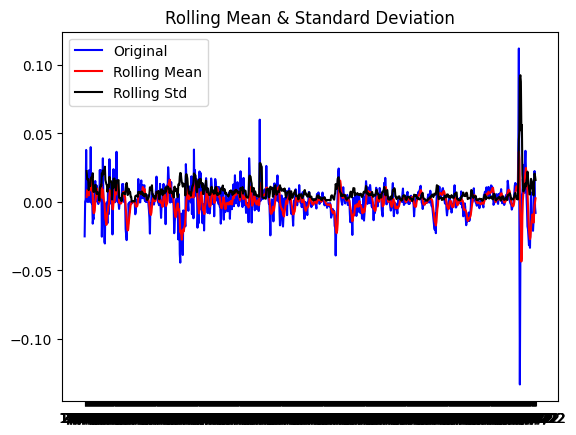

Results of Dickey-Fuller Test:
Test Statistic                -6.916066e+00
p-value                        1.178641e-09
#Lags Used                     2.100000e+01
Number of Observations Used    8.700000e+02
Critical Value (1%)           -3.437889e+00
Critical Value (5%)           -2.864868e+00
Critical Value (10%)          -2.568542e+00
dtype: float64


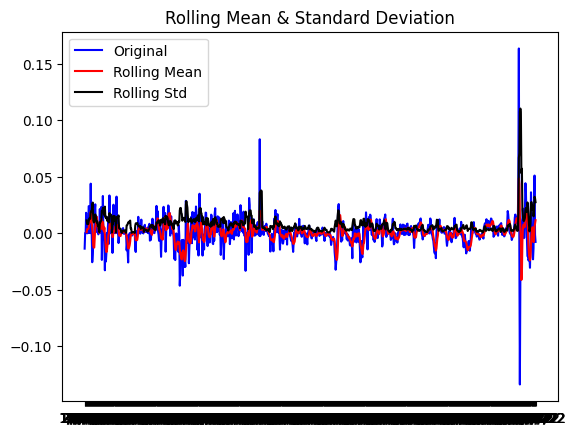

Results of Dickey-Fuller Test:
Test Statistic                -1.185620e+01
p-value                        7.018660e-22
#Lags Used                     4.000000e+00
Number of Observations Used    8.870000e+02
Critical Value (1%)           -3.437744e+00
Critical Value (5%)           -2.864804e+00
Critical Value (10%)          -2.568508e+00
dtype: float64


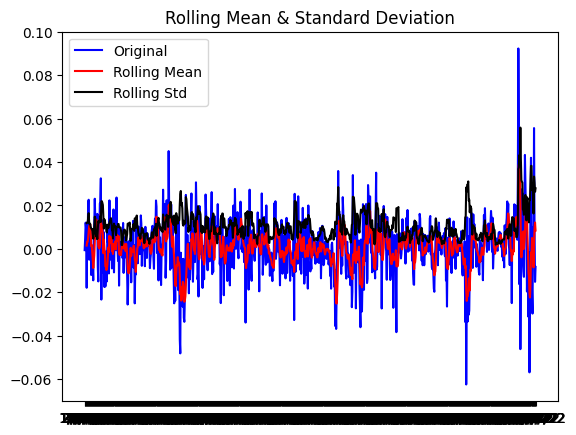

Results of Dickey-Fuller Test:
Test Statistic                -9.909286e+00
p-value                        3.200928e-17
#Lags Used                     5.000000e+00
Number of Observations Used    8.860000e+02
Critical Value (1%)           -3.437752e+00
Critical Value (5%)           -2.864808e+00
Critical Value (10%)          -2.568510e+00
dtype: float64


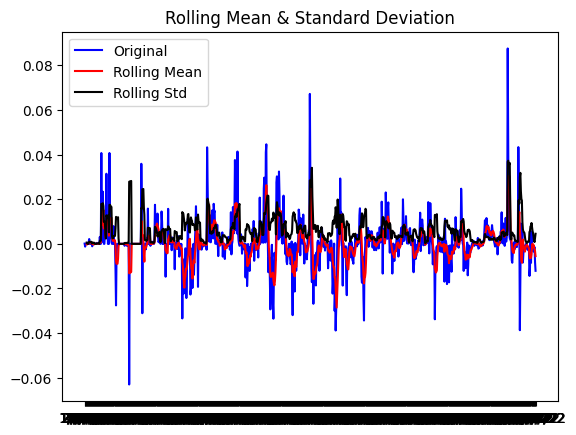

Results of Dickey-Fuller Test:
Test Statistic                -9.875077e+00
p-value                        3.901955e-17
#Lags Used                     3.000000e+00
Number of Observations Used    8.880000e+02
Critical Value (1%)           -3.437735e+00
Critical Value (5%)           -2.864800e+00
Critical Value (10%)          -2.568506e+00
dtype: float64


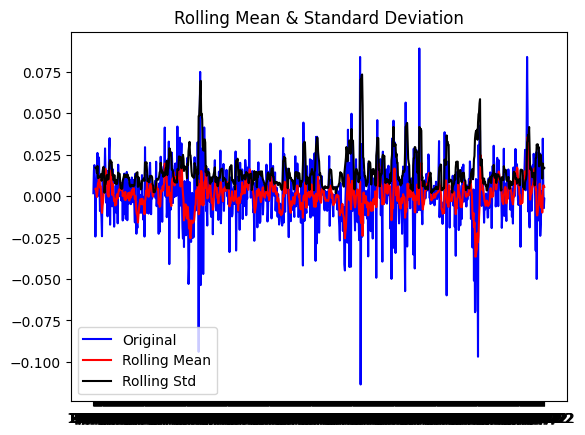

Results of Dickey-Fuller Test:
Test Statistic                -1.151145e+01
p-value                        4.250111e-21
#Lags Used                     4.000000e+00
Number of Observations Used    8.870000e+02
Critical Value (1%)           -3.437744e+00
Critical Value (5%)           -2.864804e+00
Critical Value (10%)          -2.568508e+00
dtype: float64


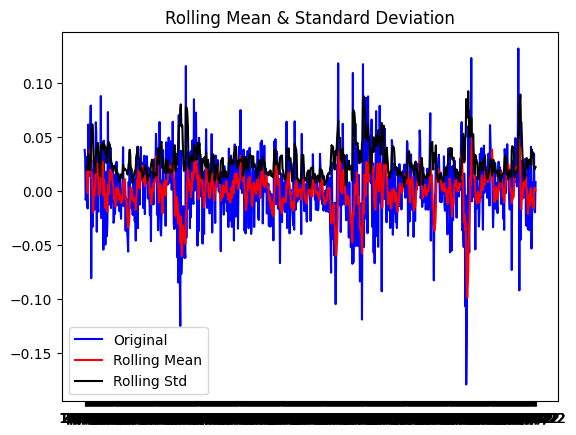

Results of Dickey-Fuller Test:
Test Statistic                -1.416255e+01
p-value                        2.068890e-26
#Lags Used                     2.000000e+00
Number of Observations Used    8.890000e+02
Critical Value (1%)           -3.437727e+00
Critical Value (5%)           -2.864797e+00
Critical Value (10%)          -2.568504e+00
dtype: float64


In [312]:
test_stationarity(eurofuel_log_diff)
test_stationarity(automotive_oil_log_diff)
test_stationarity(heating_gas_log_diff)
test_stationarity(lpg_log_diff)
test_stationarity(residual_fuel_log_diff)
test_stationarity(heavy_oil_log_diff)

### Deciding parameters for ARIMA(p,d,q) Model
The predictors depend on the parameters (p,d,q) of the ARIMA model:

#### Number of AR (Auto-Regressive) terms (p):
AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

#### Number of MA (Moving Average) terms (q):
MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


#### Number of Differences (d):

These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers.

#### Autocorrelation Function (ACF):
It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).


#### Partial Autocorrelation Function (PACF):
This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [315]:
lag_acf = acf(eurofuel_log_diff, nlags=20)
lag_pacf = pacf(eurofuel_log_diff, nlags=20, method='ols')
lag_acf = acf(automotive_oil_log_diff, nlags=20)
lag_pacf = pacf(automotive_oil_log_diff, nlags=20, method='ols')
lag_acf = acf(heating_gas_log_diff, nlags=20)
lag_pacf = pacf(heating_gas_log_diff, nlags=20, method='ols')
lag_acf = acf(lpg_log_diff, nlags=20)
lag_pacf = pacf(lpg_log_diff, nlags=20, method='ols')
lag_acf = acf(residual_fuel_log_diff, nlags=20)
lag_pacf = pacf(residual_fuel_log_diff, nlags=20, method='ols')
lag_acf = acf(heavy_oil_log_diff, nlags=20)
lag_pacf = pacf(heavy_oil_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

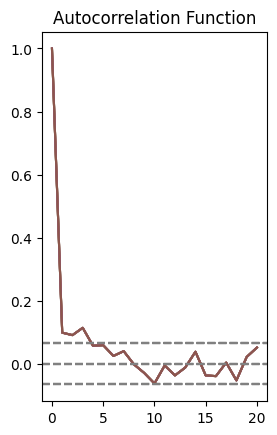

In [316]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(heavy_oil_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(heavy_oil_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_fuel_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_fuel_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lpg_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lpg_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(heating_gas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(heating_gas_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(automotive_oil_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(automotive_oil_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(eurofuel_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(eurofuel_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

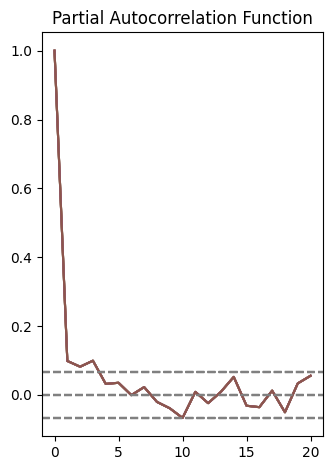

In [317]:

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(automotive_oil_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(automotive_oil_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(heating_gas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(heating_gas_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lpg_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lpg_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(residual_fuel_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual_fuel_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(heavy_oil_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(heavy_oil_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(eurofuel_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(eurofuel_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()



### Determining p, q values for all fuel types:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time, being an integer (round off to upper value if not sure). If you notice closely, in this case p=2.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time, being an integer (round off to upper value if not sure). If you notice closely, in this case q=2.

### We did all the above steps to figure out the value to use for p and q in ARIMA model

Now we will start the forecasting process

In [318]:
train_size = int(len(eurofuel) * 0.8)
train_data, test_data = eurofuel.iloc[:train_size], eurofuel.iloc[train_size:]

In [319]:
train_data

,price
survey_date,
1/3/05,1115.75
1/10/05,1088.00
1/17/05,1088.14
1/24/05,1090.01
1/31/05,1132.11
...,...
4/15/19,1604.64
4/22/19,1615.23
4/29/19,1625.87


In [320]:
test_data

,price
survey_date,
5/20/19,1624.17
5/27/19,1631.14
6/3/19,1621.90
6/10/19,1605.95
6/17/19,1595.79
...,...
10/3/22,1632.81
10/10/22,1659.78
10/17/22,1697.59


### Using ARIMA Model to do the forecasting


In [249]:
model = ARIMA(train_data, order=(2,2,0))
model_fit = model.fit()

/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [250]:
predictions = model_fit.forecast(steps=len(test_data))

/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [251]:
rmse = mean_squared_error(test_data, predictions, squared=False)
print('RMSE:', rmse)

RMSE: 175.79176666093485


In [252]:
future_predictions = model_fit.forecast(steps=30)

/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [253]:
future_predictions

714    1627.660010
715    1628.978350
716    1629.515194
717    1630.500972
718    1631.508625
719    1632.391323
720    1633.318558
721    1634.260234
722    1635.184585
723    1636.112159
724    1637.042922
725    1637.971569
726    1638.900241
727    1639.829451
728    1640.758438
729    1641.687375
730    1642.616390
731    1643.545387
732    1644.474371
733    1645.403365
734    1646.332358
735    1647.261349
736    1648.190341
737    1649.119333
738    1650.048325
739    1650.977317
740    1651.906308
741    1652.835300
742    1653.764292
743    1654.693284
Name: predicted_mean, dtype: float64

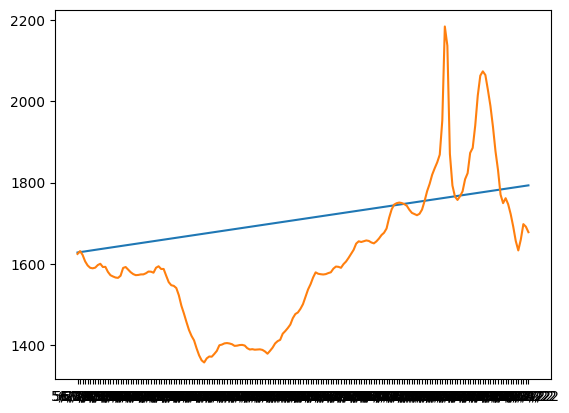

In [254]:
plt.plot(test_data.index,predictions)
plt.plot(test_data.index, test_data.values, label='Actual')

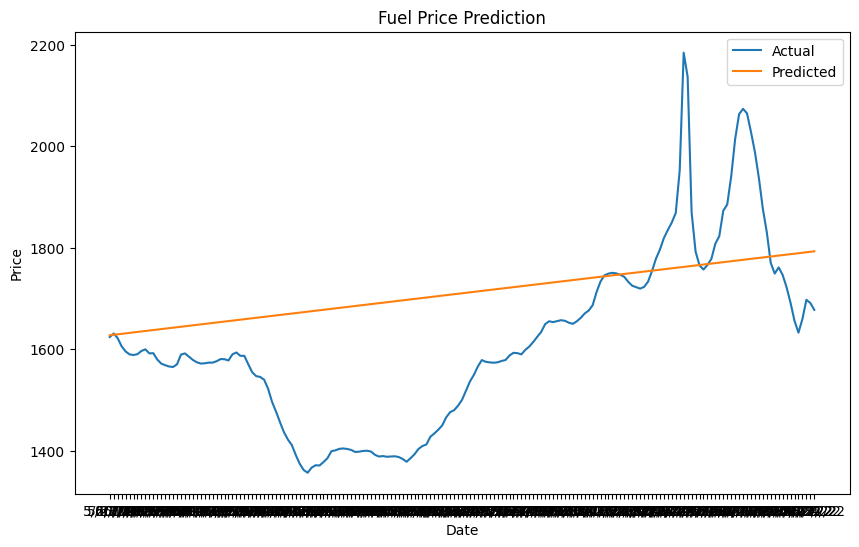

In [255]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.title('Fuel Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [256]:
percentage_error = (174 / 1506) * 100
percentage_error

11.553784860557768

In [257]:
test_data['price'].describe

<bound method NDFrame.describe of survey_date
5/20/19     1624.17
5/27/19     1631.14
6/3/19      1621.90
6/10/19     1605.95
6/17/19     1595.79
             ...   
10/3/22     1632.81
10/10/22    1659.78
10/17/22    1697.59
10/24/22    1691.24
10/31/22    1677.74
Name: price, Length: 179, dtype: float64>

### Now we will analyse data using LSTM

In [259]:
#sale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_eurofuel = scaler.fit_transform(eurofuel.values)
scaled_data_automotive_oil = scaler.fit_transform(automotive_oil.values)
scaled_data_heating_gas = scaler.fit_transform(heating_gas.values)
scaled_data_lpg = scaler.fit_transform(lpg.values)
scaled_data_residual_fuel = scaler.fit_transform(residual_fuel.values)
scaled_data_heavy_oil = scaler.fit_transform(heavy_oil.values)


In [260]:
train_data_eurofuel = scaled_data_eurofuel[0:training_data_eurofuel,:]
train_data_automotive_oil = scaled_data_automotive_oil[0:training_data_automotive_oil,:]
train_data_heating_gas = scaled_data_heating_gas[0:training_data_heating_gas,:]
train_data_lpg = scaled_data_lpg[0:training_data_lpg,:]
train_data_residual_fuel = scaled_data_residual_fuel[0:training_data_residual_fuel,:]
train_data_heavy_oil = scaled_data_heavy_oil[0:training_data_heavy_oil,:]

In [280]:
X = train_data_eurofuel
train_size_eurofuel = int(len(X) * 0.66)
train, test = X[0:train_size_eurofuel], X[train_size_eurofuel:len(X)]

In [281]:
x_train_eurofuel=[]
y_train_eurofuel=[]
for i in range (60, len(train_data_eurofuel)):
  x_train_eurofuel.append(train_data_eurofuel[i-60:i,0])
  y_train_eurofuel.append(train_data_eurofuel[i,0])
  if i<=61:
    print(x_train_eurofuel)
    print(y_train_eurofuel)
    print()

[array([0.03004701, 0.00486415, 0.0049912 , 0.0066882 , 0.04489355,
       0.04830572, 0.04831479, 0.04845999, 0.04845999, 0.06909632,
       0.09370746, 0.09378006, 0.09554059, 0.13949035, 0.13949035,
       0.13816542, 0.13816542, 0.12046028, 0.10751947, 0.09403416,
       0.09403416, 0.10456105, 0.12125887, 0.12142222, 0.1348077 ,
       0.14805706, 0.14838376, 0.14976314, 0.14797539, 0.14848358,
       0.14848358, 0.17510935, 0.17642521, 0.20350473, 0.22433163,
       0.1940396 , 0.19128083, 0.22921393, 0.23160971, 0.22817032,
       0.19324101, 0.15805761, 0.15648765, 0.14820226, 0.13066047,
       0.13027025, 0.11304608, 0.11965261, 0.13194003, 0.12213006,
       0.15705937, 0.16068025, 0.1610251 , 0.1612429 , 0.15930087,
       0.15906492, 0.1322395 , 0.13042452, 0.15733162, 0.15733162])]
[0.16259505962212095]

[array([0.03004701, 0.00486415, 0.0049912 , 0.0066882 , 0.04489355,
       0.04830572, 0.04831479, 0.04845999, 0.04845999, 0.06909632,
       0.09370746, 0.09378006, 0.09

In [282]:
#converting x_train and y_train to numpy array
x_train_eurofuel, y_train_eurofuel = np.array(x_train_eurofuel), np.array(y_train_eurofuel)

In [283]:

x_train_eurofuel = np.reshape(x_train_eurofuel, (x_train_eurofuel.shape[0], x_train_eurofuel.shape[1], 1))
x_train_eurofuel.shape

(655, 60, 1)

In [284]:
#build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train_eurofuel.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/Users/sumitkumar/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [285]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [286]:
model.fit(x_train_eurofuel, y_train_eurofuel, batch_size=1,epochs=1)

655/655 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0063


In [287]:
test_data = scaled_data_eurofuel[training_data_eurofuel - 60: , :]

In [288]:
x_test = []
y_test = scaled_data_eurofuel[training_data_eurofuel:, :]
for i in range (60, len(test_data)):
  x_test.append(test_data[i -60:i, 0])

In [289]:
x_test = np.array(x_test)

In [290]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [291]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [292]:
y_test=scaler.inverse_transform(y_test)

In [293]:
rmse = np.sqrt( np.mean( predictions - y_test)**2 )
rmse

13.53104071524562

In [301]:
train = scaled_data_eurofuel[:training_data_eurofuel]
train=scaler.inverse_transform(train)
valid['Expected'] = scaler.inverse_transform(scaled_data_eurofuel[training_data_eurofuel:])
valid=pd.DataFrame(valid)
train=pd.DataFrame(train)
valid['Predictions'] = predictions

In [302]:
valid[['Predictions','Expected']]

,Predictions,Expected
0,548.799500,536.211360
1,550.599731,530.829563
2,550.744507,521.539557
3,548.489136,515.621911
4,544.349182,512.255376
...,...,...
173,584.260803,537.184044
174,571.189209,552.892599
175,563.163513,574.914863
176,562.568604,571.216334


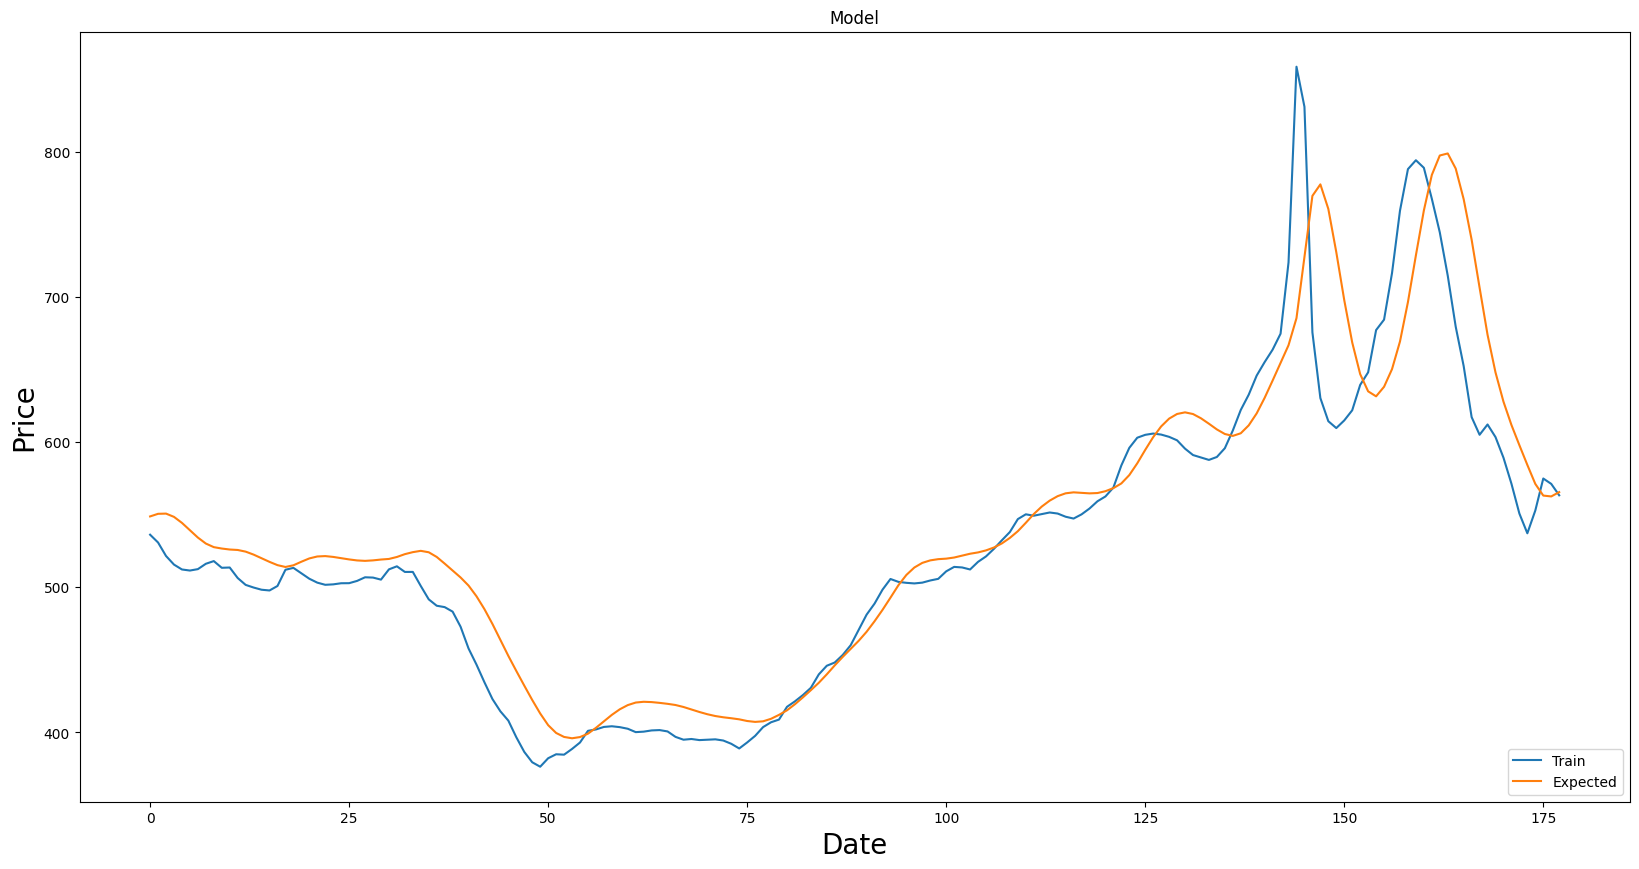

In [306]:
plt.figure(figsize=(20,10))
plt.title('Model')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)

plt.plot(valid[[0, 'Predictions']])
plt.legend(['Train', 'Expected','Predictions'], loc='lower right')
plt.show()

In [304]:
rmse = np.sqrt( np.mean( valid['Predictions'] - valid['Expected'])**2 )
rmse

13.53104071524562

The plot shows that LSTM is almost tracing the same pathway as the expected values.

In [322]:

git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/leeladhara/TimeSeries-forecasting.git
git push -u origin main

SyntaxError: invalid syntax (2794534399.py, line 1)